Load packages:

In [ ]:
# For downloading our dataset:
import torchvision
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms 

# For our model:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn  import functional as F 
from torch.autograd import Variable

# Library for working with arrays:
import numpy as np 

# For Euler's method:
import math

# Progressbar decorator for iterators:
from tqdm import tqdm_notebook as tqdm

use_cuda = torch.cuda.is_available()

Download the MRI scans:

In [ ]:
!wget https://github.com/veragnezdilova/lq_mri/archive/master.zip -O master.zip
!unzip master.zip

--2022-06-01 01:54:14--  https://github.com/veragnezdilova/lq_mri/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/veragnezdilova/lq_mri/zip/refs/heads/master [following]
--2022-06-01 01:54:14--  https://codeload.github.com/veragnezdilova/lq_mri/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [                 <=>]  70.19M  20.4MB/s    in 3.5s    

2022-06-01 01:54:18 (20.3 MB/s) - ‘master.zip’ saved [73604898]

Archive:  master.zip
961b589f008be1053bb64affe76937f01a1be246
   creating: lq_mri-master/
   creating: lq_mri-master/test/
   creating: lq_m

Build our datasets:

In [ ]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
    '/content/lq_mri-master/train',
    transform=torchvision.transforms.ToTensor()),
          batch_size=12,
          shuffle=True
          )


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
    '/content/lq_mri-master/test',
    transform=torchvision.transforms.ToTensor()),
          batch_size=6,
          shuffle=True
          )

Building the model:


In [ ]:
# Implement Euler's method - a numerical tool for approximating values for solutions of differential equations

def eulers(z0, t0, t1, f):
    
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [ ]:
# Implement a base class for our model - a neural network of parameterized dynamics function 


#nn.Module - base class for all neural network modules.
class ODEF(nn.Module):
    # a method that computes the augmented dynamics
    def forward_with_grad(self, z, t, grad_outputs):
        # Compute f and a df/dz, a df/dp, a df/dt
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # expand batch elements after grad
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    # flatten all the parameters that the function depends on
    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)


Now, we will implement forward and backward passes of Neural ODE:


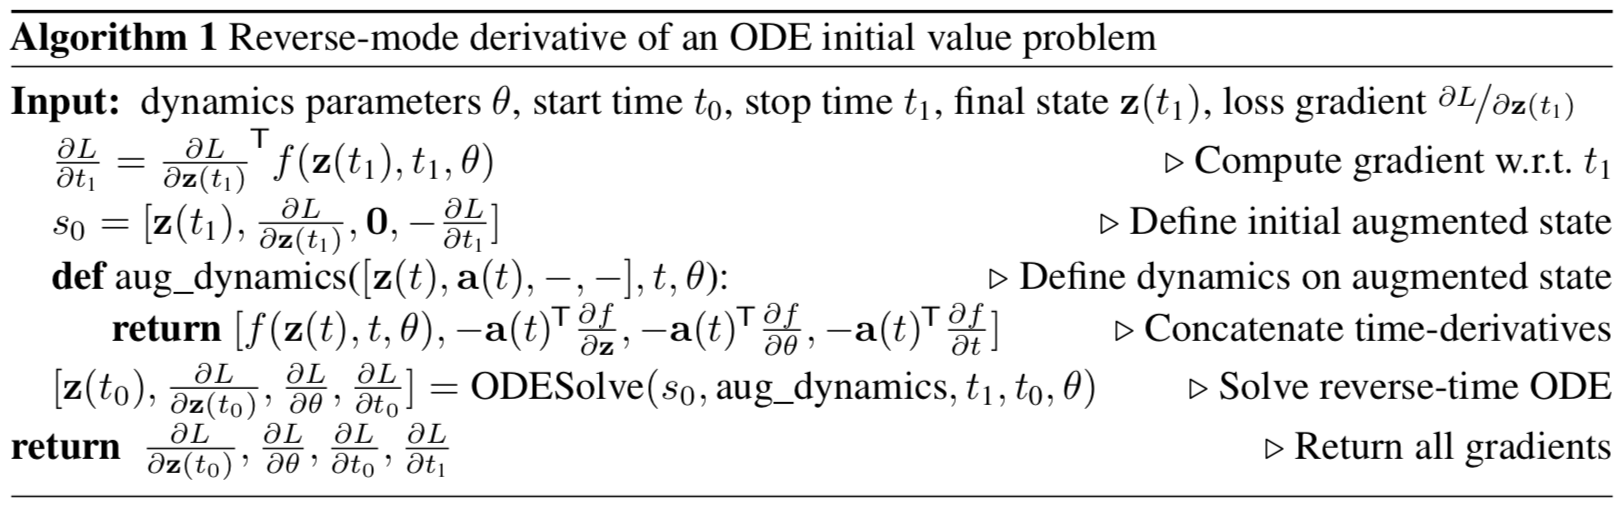



In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                #eulers
                z0 = eulers(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        def augmented_dynamics(aug_z_i, t_i):
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  
        with torch.no_grad():
            # Creating placeholders for gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)
                aug_ans = eulers(aug_z, t_i, t[i_t-1], augmented_dynamics)
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]
            
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Wrap ode adjoint function in nn.Module for convenience:

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

Now, we will use Neural ODE in place of residual blocks in our MRI classifier

In [ ]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [ ]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [ ]:
class Classifier(nn.Module):
    def __init__(self, ode):
        super(Classifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(3, 64, 3, 3),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
            
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = Classifier(ode)
if use_cuda:
    model = model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [ ]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 4
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/22 [00:00<?, ?it/s]

Train loss: 0.46076
Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/11 [00:00<?, ?it/s]

Test Accuracy: 59.091%
Training Epoch 2...


  0%|          | 0/22 [00:00<?, ?it/s]

Train loss: 0.25439
Testing...


  0%|          | 0/11 [00:00<?, ?it/s]

Test Accuracy: 83.333%
Training Epoch 3...


  0%|          | 0/22 [00:00<?, ?it/s]

Train loss: 0.24403
Testing...


  0%|          | 0/11 [00:00<?, ?it/s]

Test Accuracy: 84.848%
Training Epoch 4...


  0%|          | 0/22 [00:00<?, ?it/s]

Train loss: 0.16123
Testing...


  0%|          | 0/11 [00:00<?, ?it/s]

Test Accuracy: 92.424%


Building a graph:

In [ ]:
# For building graphics
import pandas as pd
import matplotlib.pyplot as plt
# Present our graphics as pictures
%matplotlib inline

<Figure size 648x360 with 0 Axes>

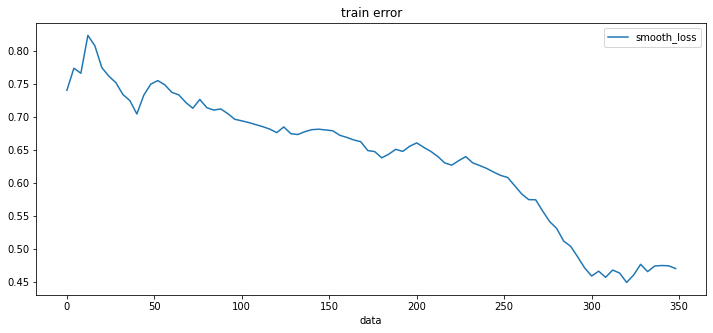

In [ ]:
plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["data"] = history.index * 4
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="data", y="smooth_loss", figsize=(12, 5), title="train error")